In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


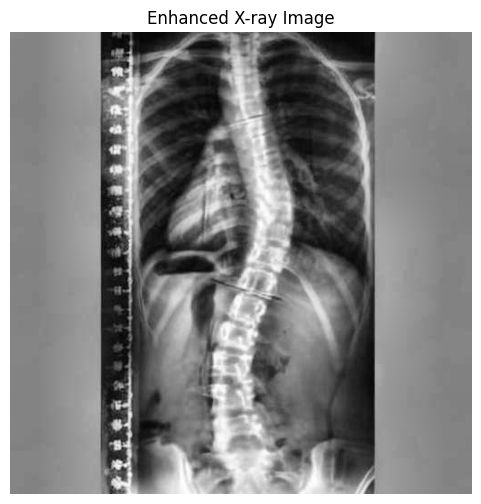

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load the X-ray image
image_path = '/content/sample.jpeg'  # Update with your image's path in Colab
xray_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Enhance the contrast using CLAHE (Contrast Limited Adaptive Histogram Equalization)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced_image = clahe.apply(xray_image)

# Save the enhanced image (optional)
cv2.imwrite('/content/enhanced_sample.jpeg', enhanced_image)

# Display the enhanced image using matplotlib
plt.figure(figsize=(6, 6))
plt.axis('off')
plt.title('Enhanced X-ray Image')
plt.imshow(enhanced_image, cmap='gray')
plt.show()

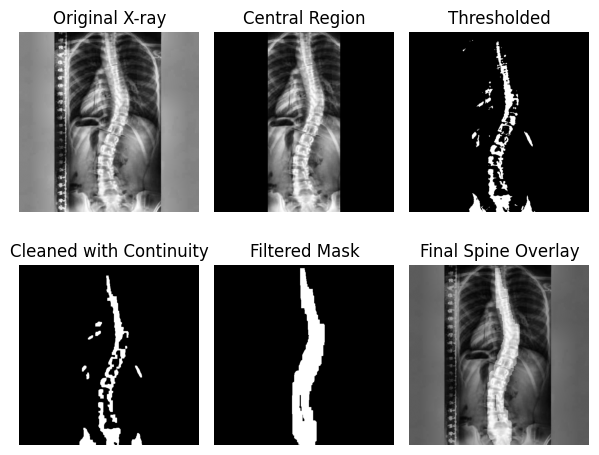

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the X-ray image (assume enhanced_image is loaded)
xray_image = enhanced_image

# Step 1: Apply a vertical mask to focus on the center of the spine
height, width = xray_image.shape
mask = np.zeros_like(xray_image)
cv2.rectangle(mask, (int(width * 0.3), 0), (int(width * 0.7), height), 255, -1)  # Wider vertical band
central_region = cv2.bitwise_and(xray_image, xray_image, mask=mask)

# Step 2: Apply intensity thresholding to isolate bright regions (spine)
_, thresholded = cv2.threshold(central_region, 200, 255, cv2.THRESH_BINARY)

# Step 3: Morphological operations to clean up the mask
kernel = np.ones((5, 5), np.uint8)
cleaned = cv2.morphologyEx(thresholded, cv2.MORPH_CLOSE, kernel)  # Connect fragmented parts
cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_OPEN, kernel)  # Remove small noise

# Step 4: Ensure vertical continuity
# Find non-zero (white) pixels
nonzero_indices = np.transpose(np.nonzero(cleaned))
for y, x in nonzero_indices:
    if np.sum(cleaned[max(0, y-10):min(height, y+10), x]) == 0:  # Check vertical gap
        cleaned[y, x] = 255  # Fill gaps to ensure continuity

# Step 5: Vertical dilation to connect regions and ensure spine is fully captured
vertical_kernel = np.ones((15, 3), np.uint8)  # Tall and narrow kernel
spine_full_height = cv2.dilate(cleaned, vertical_kernel, iterations=3)

# Step 6: Filter out small components based on height
# Connected components analysis
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(spine_full_height, connectivity=8)

# Minimum height threshold to keep the spine parts
min_height = int(height * 0.6)  # Adjust this based on the size of the spine in the image

# Create a mask to keep only the components larger than the minimum height
filtered_mask = np.zeros_like(labels, dtype=np.uint8)
for i in range(1, num_labels):  # Skip background component (index 0)
    if stats[i, cv2.CC_STAT_HEIGHT] > min_height:
        filtered_mask[labels == i] = 255

# Step 7: Apply the refined mask to isolate the spine on the original X-ray
final_spine = cv2.bitwise_and(xray_image, xray_image, mask=filtered_mask)

# Step 8: Overlay the mask on the original X-ray for better visualization
overlay = cv2.addWeighted(xray_image, 0.7, filtered_mask, 0.3, 0)
cv2.imwrite('/content/overlayed.jpeg', overlay)
cv2.imwrite('/content/filtered.jpeg', filtered_mask)

# Display the results
plt.figure(figsize=(6, 5))

plt.subplot(2, 3, 1)
plt.title("Original X-ray")
plt.imshow(xray_image, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.title("Central Region")
plt.imshow(central_region, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.title("Thresholded")
plt.imshow(thresholded, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.title("Cleaned with Continuity")
plt.imshow(cleaned, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.title("Filtered Mask")
plt.imshow(filtered_mask, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.title("Final Spine Overlay")
plt.imshow(overlay, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


Key Points Detected:
Point 1 (Start): X = 256.00, Y = 72.04
Point 2 (Max Deviation 1): X = 290.02, Y = 217.14
Point 3 (Transition): X = 251.03, Y = 324.20
Point 4 (Max Deviation 2): X = 245.01, Y = 391.27
Point 5 (End): X = 254.20, Y = 439.63
Five points detected. Processing Cobb Angle...
Top Cobb Angle: 33.20°
Bottom Cobb Angle: 15.89°
Maximum Cobb Angle: 33.20°
Curve Type: S-shaped curve
Severity: 
Moderate scoliosis: Cobb angle of 20–40 degrees. 
Bracing may be required to stop the curve from progressing.



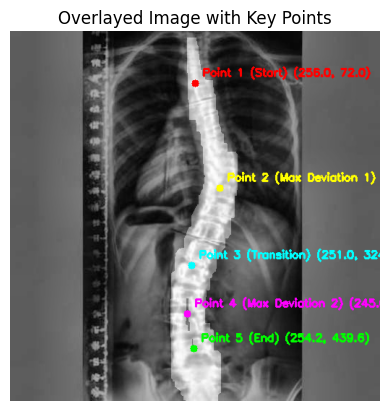

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from scipy.interpolate import UnivariateSpline

# Load the filtered image (for point extraction and processing)
filtered_image = cv2.imread('/content/filtered.jpeg', cv2.IMREAD_GRAYSCALE)
filtered_image = (filtered_image > 128).astype(np.uint8) * 255  # Ensure binary

# Step 1: Skeletonization
skeleton = skeletonize(filtered_image > 0)
coords = np.column_stack(np.where(skeleton > 0))
if len(coords) == 0:
    raise ValueError("No skeleton points detected!")

# Step 2: Sort by y-axis (top to bottom)
coords = coords[np.argsort(coords[:, 0])]
y_vals = coords[:, 0]
x_vals = coords[:, 1]

# Step 3: Fit a smooth curve
unique_y, unique_indices = np.unique(y_vals, return_index=True)
unique_x = x_vals[unique_indices]
spline = UnivariateSpline(unique_y, unique_x, k=3, s=1)

# Step 4: Sample points along the curve
num_points = 50
sample_y = np.linspace(unique_y[0], unique_y[-1], num_points)
sample_x = spline(sample_y)

# Step 5: Compute deviations from the centerline
mid_x = np.mean(sample_x)
deviations = np.abs(sample_x - mid_x)

# Step 6: Identify most deviated points (Point 2 & 4)
half_idx = len(sample_y) // 2  # Split upper and lower halves
point_2_idx = min(np.argmax(deviations[:half_idx]) + 2, half_idx - 1)  # Lowered slightly
point_4_idx = np.argmax(deviations[half_idx:]) + half_idx  # Most deviated in lower half

# Step 7: Find transition point (Point 3)
point_3_idx = (point_2_idx + point_4_idx) // 2
# Step 8: Find start (Point 1) and end (Point 5)
point_1_idx = max(0, point_2_idx + 5)  # A bit after Point 2

# Adjust Point 1 to be 2 or 3 vertebrae above the original position
vertebrae_above = 15  # Change to 2 for 2 vertebrae above or 3 for 3 vertebrae above
point_1_idx = max(0, point_2_idx - vertebrae_above)  # Shift upwards

point_5_idx = min(len(sample_x) - 1, point_4_idx + 5)  # A bit after Point 4



# Adjust Point 4 to the right and Point 5 to the left (only width-wise)
adjustment_value = 13  # Change this to control the horizontal shift

key_points = {
    "Point 1 (Start)": (sample_x[point_1_idx], sample_y[point_1_idx]),
    "Point 2 (Max Deviation 1)": (sample_x[point_2_idx], sample_y[point_2_idx]),
    "Point 3 (Transition)": (sample_x[point_3_idx]-adjustment_value, sample_y[point_3_idx]+20),
    "Point 4 (Max Deviation 2)": (sample_x[point_4_idx] + adjustment_value, sample_y[point_4_idx]),  # Right shift
    "Point 5 (End)": (sample_x[point_5_idx] - adjustment_value-5, sample_y[point_5_idx])  # Left shift
}

# Print key points with coordinates
print("\nKey Points Detected:")
for i, (label, (x, y)) in enumerate(key_points.items(), start=1):
    print(f"{label}: X = {x:.2f}, Y = {y:.2f}")

# Now load the overlayed image
overlayed_image = cv2.imread('/content/overlayed.jpeg')

# Overlay the key points on the overlayed image
colors = [(0, 0, 255), (0, 255, 255), (255, 255, 0), (255, 0, 255), (0, 255, 0)]  # Red, Cyan, Yellow, Magenta, Green

# Draw the points and labels on the overlayed image
for i, (label, (x, y)) in enumerate(key_points.items()):
    cv2.circle(overlayed_image, (int(x), int(y)), 5, colors[i], -1)
    cv2.putText(overlayed_image, f'{label} ({x:.1f}, {y:.1f})',
                (int(x) + 10, int(y) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[i], 2)

def process_cobb_angle():
    global clicked_points
    if len(clicked_points) < 6:  # Since we now expect 6 points due to duplication
        with output:
            print("Not enough points to calculate Cobb angle.")
        return

    # Split clicked points into two groups for two curves
    top_points = clicked_points[:3]
    bottom_points = clicked_points[3:]

    # Calculate Cobb angles for top and bottom curves
    top_cobb_angle = calculate_cobb_angle(top_points)
    bottom_cobb_angle = calculate_cobb_angle(bottom_points)

    # Determine maximum Cobb angle and corresponding points
    if top_cobb_angle > bottom_cobb_angle:
        max_cobb_angle = top_cobb_angle
        max_points = top_points
    else:
        max_cobb_angle = bottom_cobb_angle
        max_points = bottom_points

    # Determine curve type
    if top_cobb_angle >= 15 and bottom_cobb_angle >= 15:
        curve_type = "S-shaped curve"
    elif top_cobb_angle >= 15 or bottom_cobb_angle >= 15:
        curve_type = "C-shaped curve"
    else:
        curve_type = "No significant curve detected"

    # Determine severity
    if 15 < max_cobb_angle < 20:
        severity = (
            "Mild scoliosis: Cobb angle of 10–20 degrees. \n"
            "Usually observed without treatment, and exercise treatment may be recommended.\n"
        )
    elif 20 <= max_cobb_angle <= 40:
        severity = (
            "Moderate scoliosis: Cobb angle of 20–40 degrees. \n"
            "Bracing may be required to stop the curve from progressing.\n"
        )
    else:
        severity = (
            "Severe scoliosis: Cobb angle of more than 40 degrees. \n"
            "Spinal fusion surgery may be required to correct the curve.\n"
        )

    # Display resul
    print(f"Top Cobb Angle: {top_cobb_angle:.2f}°")
    print(f"Bottom Cobb Angle: {bottom_cobb_angle:.2f}°")
    print(f"Maximum Cobb Angle: {max_cobb_angle:.2f}°")
    print(f"Curve Type: {curve_type}")
    print(f"Severity: \n{severity}")




# Calculate the Cobb angle using three points
def calculate_cobb_angle(points):
    # Get the coordinates of the three points
    x1, y1 = points[0]
    x2, y2 = points[1]
    x3, y3 = points[2]

    # Calculate the slopes of the two lines
    m1 = (y2 - y1) / (x2 - x1) if x2 != x1 else float('inf')
    m2 = (y3 - y2) / (x3 - x2) if x3 != x2 else float('inf')

    # Calculate the angle between the two lines in radians
    if m1 == float('inf') or m2 == float('inf'):
        angle_rad = np.pi / 2  # 90 degrees if one line is vertical
    else:
        angle_rad = abs(np.arctan((m2 - m1) / (1 + m1 * m2)))

    # Convert angle to degrees
    angle_deg = np.degrees(angle_rad)
    return angle_deg


clicked_points = list(key_points.values())
if len(clicked_points) == 5:
    # Duplicate the third point to act as both the last of the top curve and the first of the bottom curve
    clicked_points.insert(3, clicked_points[2])
    print("Five points detected. Processing Cobb Angle...")
    process_cobb_angle()


# Step 9: Plot the overlayed image with points
plt.imshow(cv2.cvtColor(overlayed_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Overlayed Image with Key Points")
plt.show()
